In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syifbhuiyan","key":"6bde8dbb02209359cd8fba7b6deea8d8"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle

In [4]:
!kaggle competitions download -c home-credit-default-risk
!unzip -q home-credit-default-risk.zip

 96% 662M/688M [00:10<00:00, 71.0MB/s]
100% 688M/688M [00:11<00:00, 65.1MB/s]


In [8]:
import pandas as pd
import numpy as np

# Load the main dataset
df = pd.read_csv('application_train.csv')

# 1. Transform Age: Convert negative days to positive years using the specific column
df['AGE'] = df['DAYS_BIRTH'].abs() / 365.25

# 2. Clean Gender: Remove rows where gender is 'XNA' (missing)
df = df[df['CODE_GENDER'] != 'XNA']

# 3. Convert Gender: Map 'F' to 0 and 'M' to 1
# We map this on the specific column, not the whole dataframe
df['CODE_GENDER'] = df['CODE_GENDER'].map({'F': 0, 'M': 1})

# 4. Pick our signals: We use Age, Gender, and Total Income
features = ['AGE', 'CODE_GENDER', 'AMT_INCOME_TOTAL']

# Prepare X (Features) and y (Target)
X = df[features].fillna(0)
y = df['TARGET'] # 1 means risk (default); 0 means repaid

print("Data Preparation Complete.")
print(f"Features shape: {X.shape}")

Data Preparation Complete.
Features shape: (307507, 3)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
# FIX: Added class_weight='balanced' to force the model to find the risks
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)

# Generate predictions
predictions = model.predict(X_test)

print("Model Training Complete (With Balanced Weights).")

Model Training Complete (With Balanced Weights).


In [13]:
!pip install -q fairlearn
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score

# Analyze results across genders (0 = Female, 1 = Male)
metrics = {
    "accuracy": accuracy_score,
    "selection_rate": selection_rate
}

# We must isolate the sensitive feature (Gender) for the audit
audit = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=predictions,
    sensitive_features=X_test['CODE_GENDER']
)

print("--- Fairness Audit Results ---")
print(audit.by_group)

--- Fairness Audit Results ---
             accuracy  selection_rate
CODE_GENDER                          
0            0.820915        0.140239
1            0.187193        0.905855


In [16]:
from fairlearn.postprocessing import ThresholdOptimizer

# We add objective="balanced_accuracy_score" to stop it from predicting all 0s
optimizer = ThresholdOptimizer(
    estimator=model,
    constraints="demographic_parity",
    objective="balanced_accuracy_score",  # <--- THIS IS THE KEY FIX
    predict_method="predict_proba"
)

# Fit the optimizer using sensitive gender info
# Note: We use the TRAINING data to fit
optimizer.fit(X_train, y_train, sensitive_features=X_train['CODE_GENDER'])

# Generate fair predictions
# Note: We use the TEST data to predict
fair_preds = optimizer.predict(X_test, sensitive_features=X_test['CODE_GENDER'])

# Verify the improvement
fair_audit = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=fair_preds,
    sensitive_features=X_test['CODE_GENDER']
)

print("--- Balanced Results After Mitigation ---")
print(fair_audit.by_group)

--- Balanced Results After Mitigation ---
             accuracy  selection_rate
CODE_GENDER                          
0            0.589468        0.415637
1            0.588538        0.416615


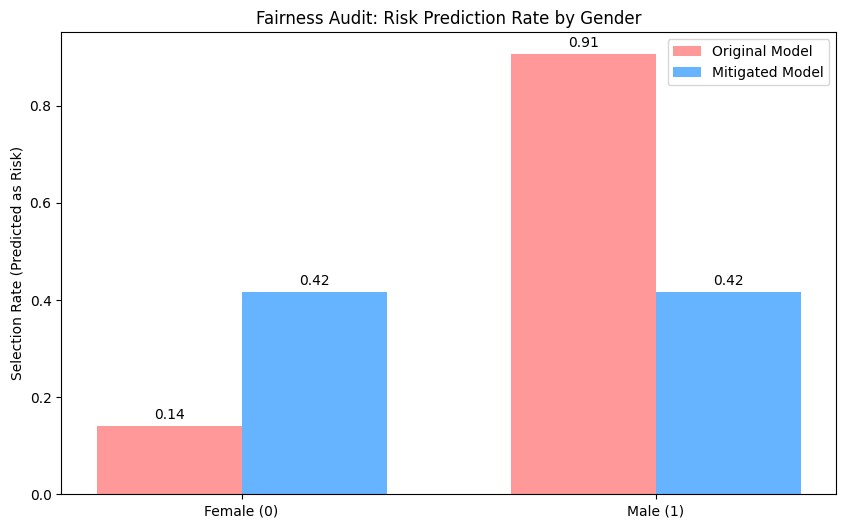

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Setup data
groups = ['Female (0)', 'Male (1)']
before_rates = audit.by_group['selection_rate']
after_rates = fair_audit.by_group['selection_rate']

x = np.arange(len(groups))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
rects1 = ax.bar(x - width/2, before_rates, width, label='Original Model', color='#ff9999')
rects2 = ax.bar(x + width/2, after_rates, width, label='Mitigated Model', color='#66b3ff')

# Add labels and title
ax.set_ylabel('Selection Rate (Predicted as Risk)')
ax.set_title('Fairness Audit: Risk Prediction Rate by Gender')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()